PyMC3 port of the [brm monotoic example](https://github.com/paul-buerkner/brms/blob/master/vignettes/brms_monotonic.Rmd)

Similar examples of doing inference on ordered data also could be found in:  
https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_11.ipynb  
https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import theano.tensor as tt
import theano

%pylab inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
Xmo_1 = np.random.choice(np.arange(4), 100)
income_options = ["below_20", "20_to_40", "40_to_100", "greater_100"]
income = pd.Series(Xmo_1, name='income').astype('category').cat.rename_categories(income_options)
mean_ls = np.asarray([30, 60, 70, 75])
ls = pd.Series((mean_ls[Xmo_1, np.newaxis] + np.random.randn(100, 1)*7).flatten(), name='ls')
dat = pd.concat([income, ls], axis=1)

In [3]:
dat.head()

,income,ls
0,greater_100,74.616329
1,40_to_100,65.347007
2,greater_100,66.140396
3,below_20,16.783733
4,below_20,34.888351


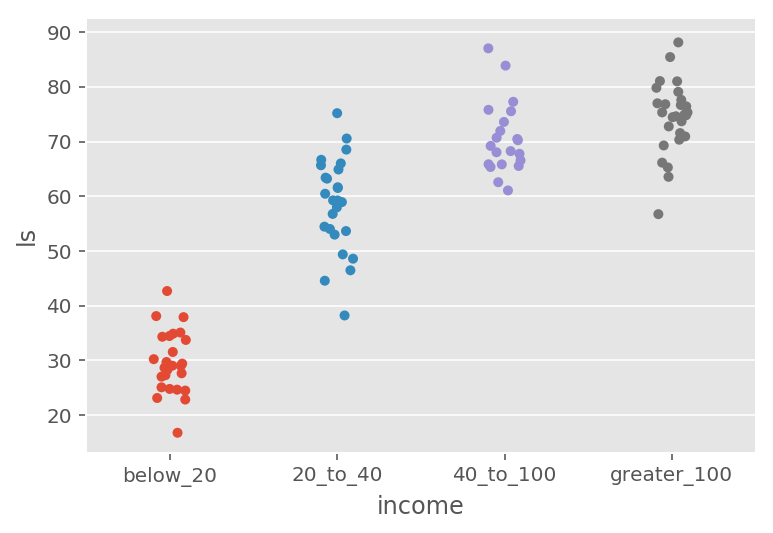

In [4]:
sns.stripplot(x="income", y="ls", data=dat, jitter=True);

In [5]:
sd_t = 20
df_t = 3
mu_t_i = np.mean(dat['ls'])
con_simo_1 = np.ones(3)

In [6]:
con_simo_1

array([1., 1., 1.])

In [7]:
Xmo_1

array([3, 2, 3, 0, 0, 0, 1, 0, 1, 3, 1, 2, 2, 0, 2, 0, 3, 1, 1, 2, 2, 1,
       3, 0, 0, 0, 2, 0, 3, 0, 0, 2, 3, 2, 1, 0, 2, 0, 1, 0, 1, 1, 2, 2,
       3, 3, 1, 2, 3, 2, 3, 0, 3, 0, 1, 0, 3, 3, 2, 1, 0, 3, 0, 3, 1, 0,
       2, 3, 1, 3, 2, 1, 1, 0, 1, 0, 3, 3, 3, 1, 0, 2, 3, 3, 1, 0, 2, 2,
       2, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1])

In [8]:
Xmo = np.zeros((len(Xmo_1), 4), int)
for ic, i in enumerate(Xmo_1):
    if i > 0:
        Xmo[ic, :i+1] = np.arange(i+1)
Xmo[:5]

array([[0, 1, 2, 3],
       [0, 1, 2, 0],
       [0, 1, 2, 3],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [9]:
dat['ls'].values

array([74.6163287 , 65.34700729, 66.14039569, 16.78373309, 34.88835083,
       33.74735331, 66.00664554, 29.01825087, 68.52436915, 71.54197014,
       49.37894319, 70.69066896, 65.82498933, 24.7940992 , 77.26225995,
       28.66461061, 72.76190999, 54.02353595, 66.66123165, 83.87333894,
       70.46299402, 59.23422165, 76.98558293, 37.91361331, 29.41436141,
       24.48886496, 68.24916994, 29.71231949, 70.93115494, 35.09437712,
       30.23401539, 62.56755864, 69.28067103, 75.53563275, 48.59128009,
       34.46045242, 68.03950211, 27.65667645, 58.93805217, 28.29009596,
       59.24990675, 61.64899403, 61.06355676, 75.7932224 , 76.42632221,
       73.69686024, 54.44451263, 70.23701259, 65.2646536 , 73.57979639,
       79.07570993, 42.68416593, 76.81575739, 24.65918896, 70.55190431,
       38.10560577, 75.32602573, 74.80983211, 65.53488321, 46.47107262,
       31.54543486, 76.67675165, 23.13829472, 88.11309308, 53.64340463,
       27.30083685, 66.5494615 , 74.93569409, 75.1798751 , 81.04

In [10]:
a = theano.shared(np.zeros(1,))
with pm.Model() as fit1:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sd=sd_t, nu=df_t)
    beta = pm.Normal('bmo', mu=0., sd=100.)
    simo_1 = pm.Dirichlet('simo_1', a=con_simo_1)
    simo = tt.concatenate([a, simo_1])
    sigma = pm.HalfStudentT('sigma', sd=sd_t, nu=df_t)
    mu = temp_Intercept + beta * tt.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sd=sigma, observed=dat['ls'].values)
    trace1 = pm.sample(2000, njobs=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, simo_1_stickbreaking__, bmo, intercept]
 20%|██        | 615/3000 [00:08<00:13, 179.18it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '3740' (I am process '3741')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
100%|██████████| 3000/3000 [00:25<00:00, 117.18it/s]


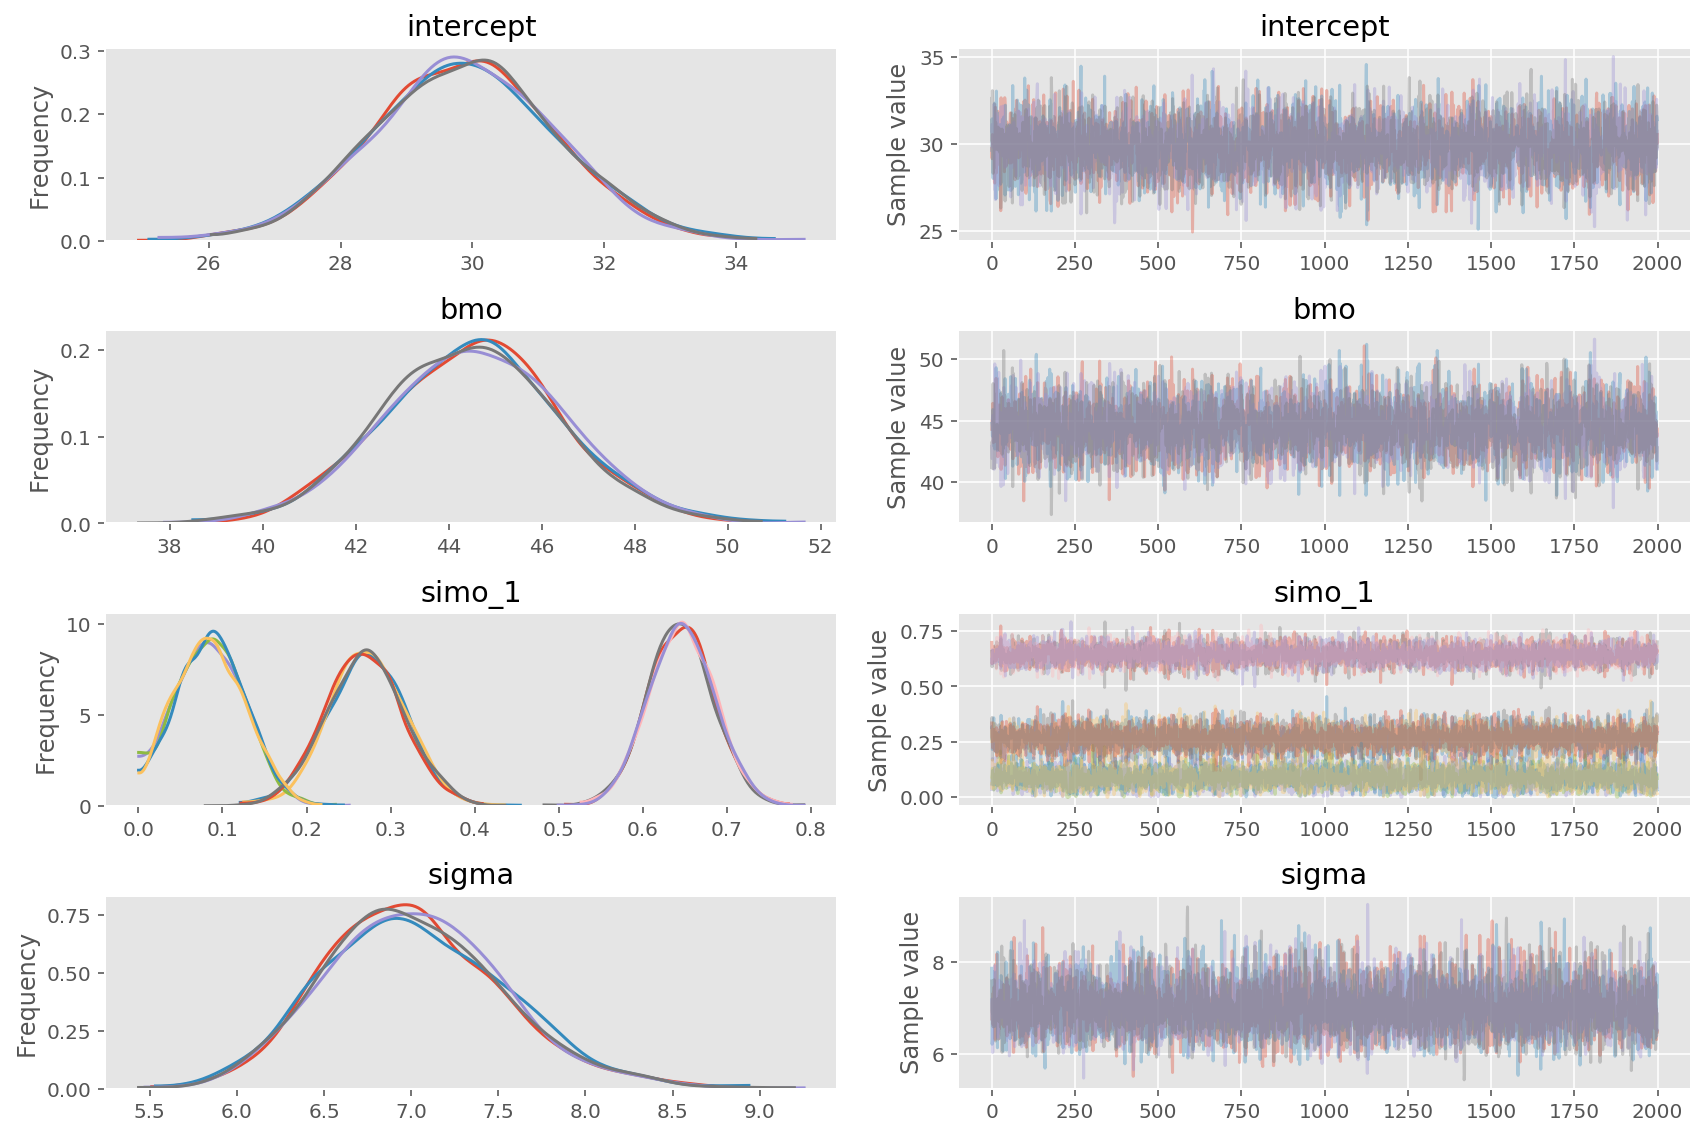

In [11]:
pm.traceplot(trace1);

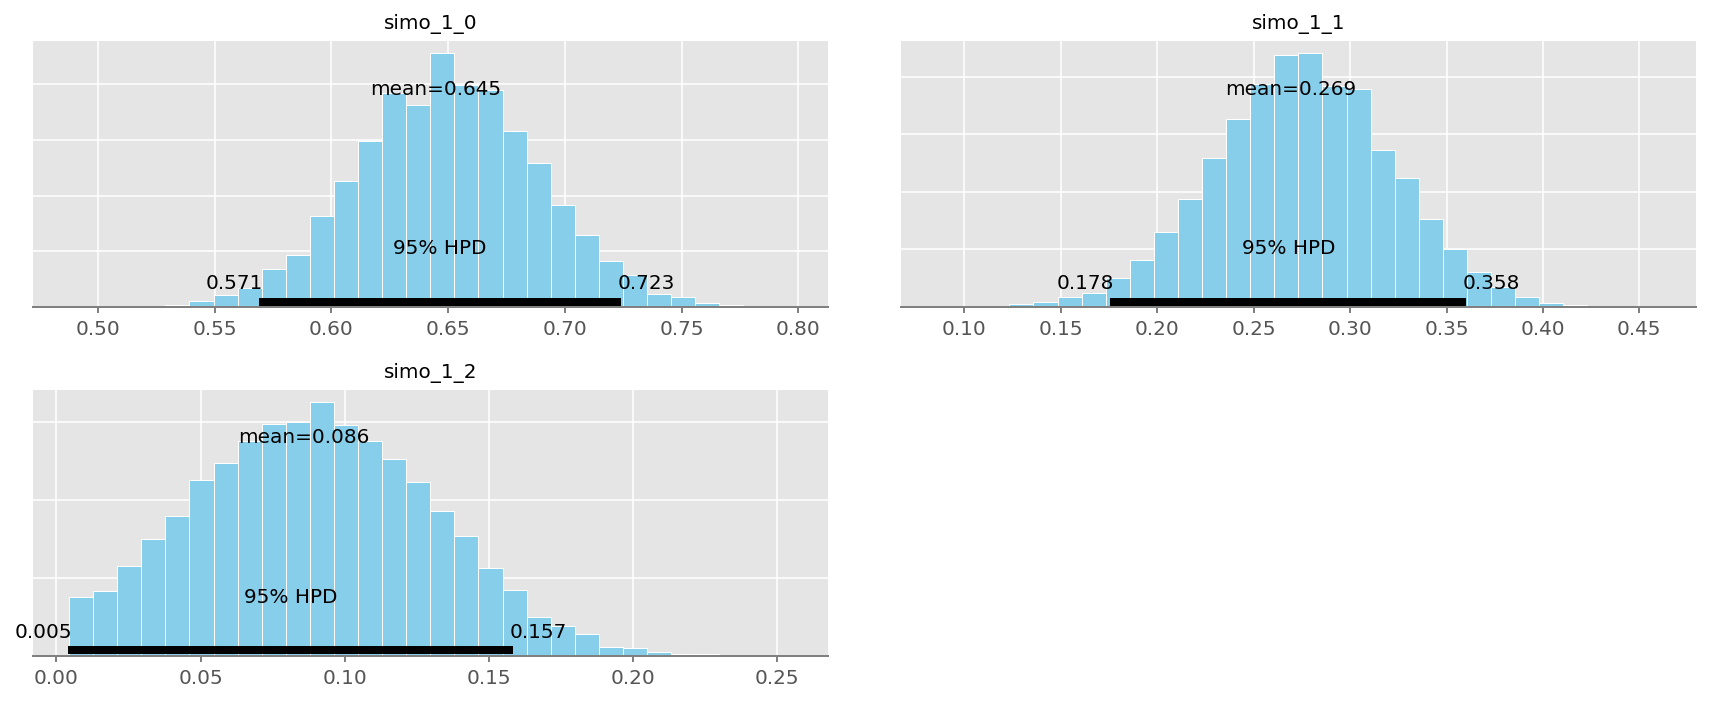

In [12]:
pm.plot_posterior(trace1, varnames=['simo_1'], color='#87ceeb');

In [13]:
Xc = Xmo_1 - Xmo_1.mean()
df_t2 = 21
with pm.Model() as fit2:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sd=sd_t, nu=df_t2)
    beta = pm.Normal('bmo', mu=0., sd=100.)
    sigma = pm.HalfStudentT('sigma', sd=sd_t, nu=df_t2)
    mu = temp_Intercept + beta * Xc
    obs = pm.Normal('Y', mu=mu, sd=sigma, observed=dat['ls'].values)
    trace2 = pm.sample(2000, njobs=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, bmo, intercept]
100%|██████████| 3000/3000 [00:07<00:00, 424.66it/s]


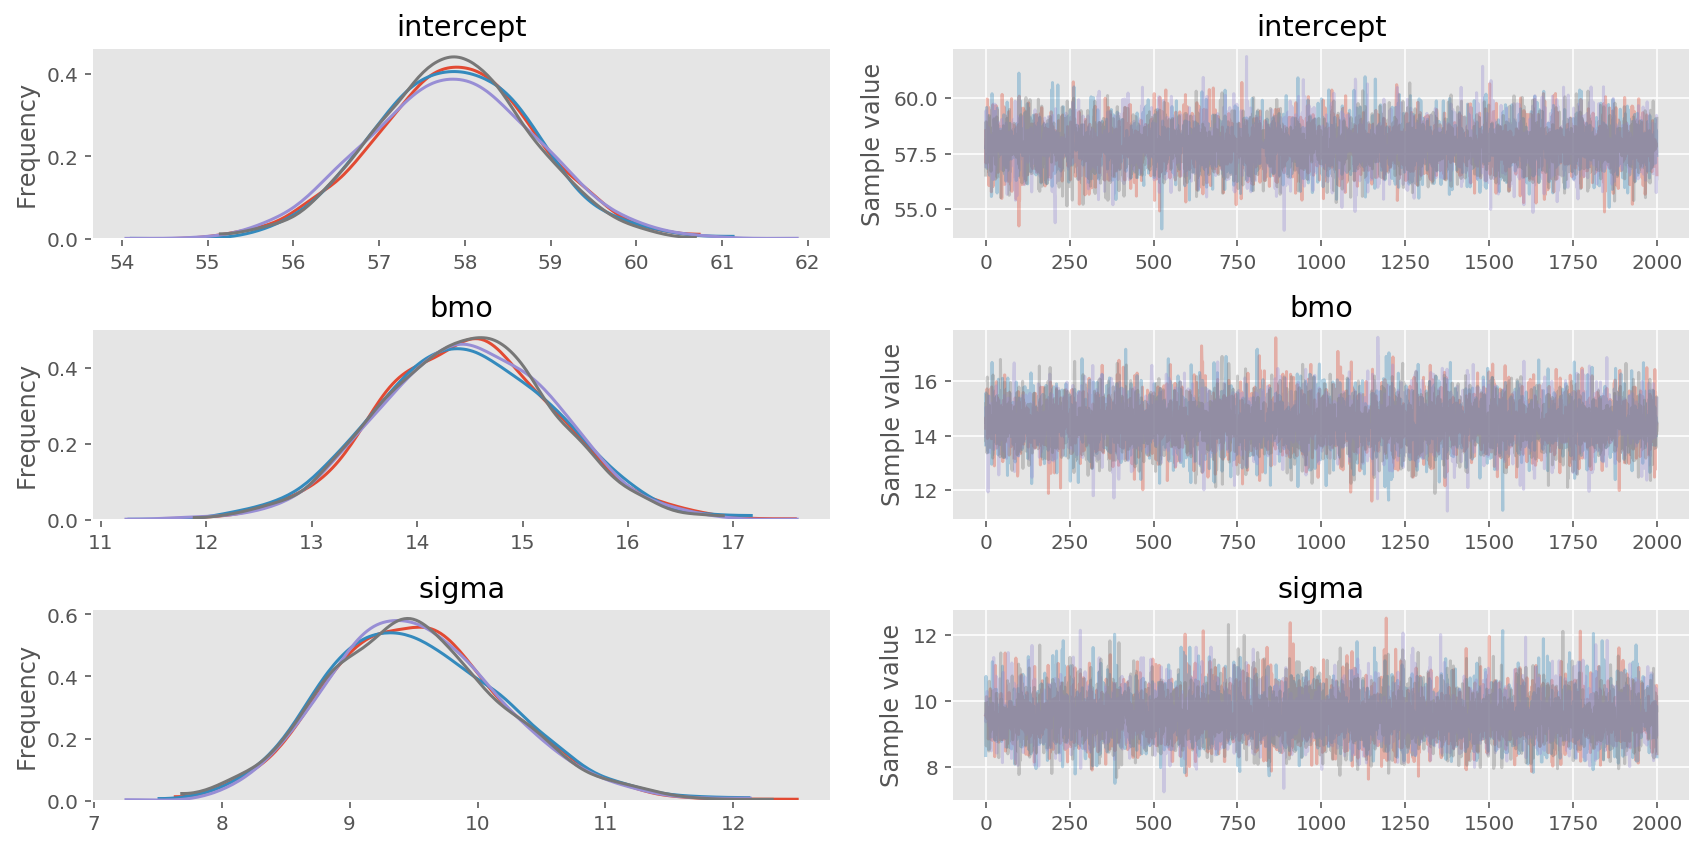

In [14]:
pm.traceplot(trace2);

In [15]:
from patsy import dmatrices
y, X = dmatrices('ls ~ income', data=dat)
X = np.asarray(X)

In [16]:
Xc = X[:, 1:] - X[:, 1:].mean(axis=0, keepdims=True)
df_t2 = 21
with pm.Model() as fit3:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sd=sd_t, nu=df_t2)
    beta = pm.Normal('bmo', mu=0., sd=100., shape=Xc.shape[1])
    sigma = pm.HalfStudentT('sigma', sd=sd_t, nu=df_t2)
    mu = temp_Intercept + tt.dot(Xc, beta)
    obs = pm.Normal('Y', mu=mu, sd=sigma, observed=dat['ls'].values)
    trace3 = pm.sample(2000, njobs=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, bmo, intercept]
100%|██████████| 3000/3000 [00:09<00:00, 332.63it/s]


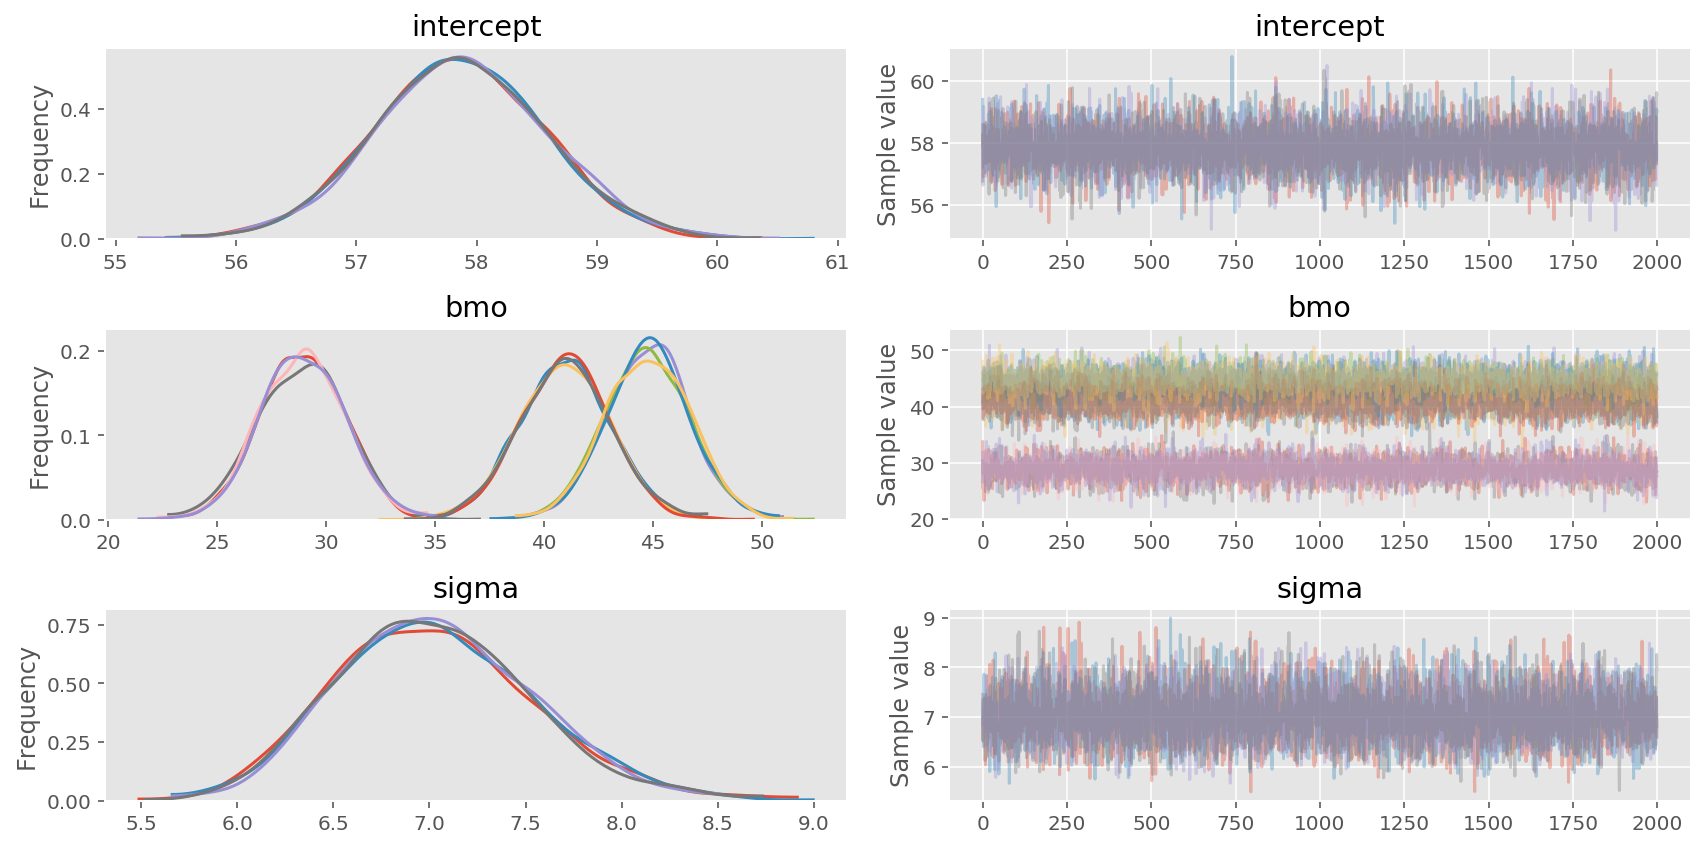

In [17]:
pm.traceplot(trace3);

In [18]:
MODEL_NAME_MAP = {
    0: "fit1",
    1: "fit2",
    2: "fit3",
}

comp_df = (pm.compare([trace1, trace2, trace3], 
                      [fit1, fit2, fit3],
                      ic='LOO')
             .rename(index=MODEL_NAME_MAP)
             .loc[MODEL_NAME_MAP.values()])

comp_df

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
fit1,677.26,4.98,0,0.97,16.08,0,0
fit2,736.12,2.67,58.86,0.03,13.58,12.84,0
fit3,677.31,4.99,0.05,0,16,0.28,0


In [19]:
pm.compare([trace1, trace2, trace3], 
           [fit1, fit2, fit3],
           ic='WAIC')

/Users/jlao/Documents/Github/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
0,677.21,4.95,0,0.97,16.07,0,1
2,677.29,4.98,0.07,0,15.99,0.27,1
1,736.11,2.67,58.89,0.03,13.57,12.82,0


In [20]:
pm.compare([trace1, trace2, trace3], 
           [fit1, fit2, fit3],
           ic='LOO', method='BB-pseudo-BMA')

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
0,677.26,4.98,0,0.51,15.8,0,0
2,677.31,4.99,0.05,0.49,15.71,0.28,0
1,736.12,2.67,58.86,0,13.85,12.84,0


In [21]:
pm.waic(trace1, fit1)

/Users/jlao/Documents/Github/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=677.2140938606045, WAIC_se=16.06626025874376, p_WAIC=4.954990243022885, var_warn=1)

In [22]:
pm.waic(trace2, fit2)

WAIC_r(WAIC=736.1064814314448, WAIC_se=13.573954653617285, p_WAIC=2.667566466360168, var_warn=0)

In [23]:
pm.waic(trace3, fit3)

/Users/jlao/Documents/Github/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=677.2879510712852, WAIC_se=15.994278025893834, p_WAIC=4.976715698684752, var_warn=1)